In [1]:
import pandas as pd
import numpy as np
import os
import dill
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import dill
from sklearn.metrics import accuracy_score
import os
from sklearn.preprocessing import TargetEncoder

In [2]:
states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
    "PR",
]

In [3]:
csv_files = [
    (pd.read_csv(os.path.join("../data/Income_acs", file)), file.split(".")[0])
    for file in os.listdir("../data/Income_acs")
    if file.endswith(".csv")
]

for df, _ in csv_files:
    df.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
features = [
    "AGEP",
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "WKHP",
    "SEX",
    "RAC1P",
]
col = [">50K"]
for df, _ in csv_files:
    df.columns = features + ["Gender", ">50K"]
    df.drop("Gender", axis=1, inplace=True)

    # df['SCHL'] = df['SCHL'].apply(lambda x: 0 if x <= 17 else (1 if 18 <= x <= 21 else 2))
    df["SEX"] = df["SEX"].apply(lambda x: 0 if x == 1 else 1)

In [5]:
reduced_df_list = []
accuracy_list = []
for df, state in csv_files:
    dataset_size = len(df)
    frac = 20000
    if dataset_size > frac:
        df = df.sample(n=frac, random_state=42)

    # store to disk the sampled dataset
    df.to_csv(
        f"/raid/lcorbucci/folktables/income_data_reduced/{state}_reduced.csv",
        index=False,
    )
    reduced_df_list.append(df)
    # X = df[all_features]
    # Y = df[col]

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    # model = LogisticRegression()
    # model.fit(X_train, Y_train)

    # Y_pred = model.predict(X_test)
    # accuracy = accuracy_score(Y_test, Y_pred)
    # accuracy_list.append(accuracy)

In [6]:
def pre_process_income(df):
    """
    Pre-process the income dataset to make it ready for the simulation
    In this function we consider "SEX" as the sensitive value and "PINCP" as the target value.

    Args:
        data: the raw data
        years_list: the list of years to be considered
        states_list: the list of states to be considered

    Returns:
        Returns a list of pre-processed data for each state, if multiple years are
        selected, the data are concatenated.
        We return three lists:
        - The first list contains a pandas dataframe of features for each state
        - The second list contains a pandas dataframe of labels for each state
        - The third list contains a pandas dataframe of groups for each state
        The values in the list are numpy array of the dataframes
    """

    categorical_columns = ["COW", "SCHL", "RAC1P", "SEX"]
    continuous_columns = ["AGEP", "WKHP", "OCCP", "POBP", "RELP"]

    # get the target and sensitive attributes
    target_attributes = df[">50K"]

    # convert the columns to one-hot encoding
    encoder = TargetEncoder()
    df[categorical_columns] = encoder.fit_transform(
        df[categorical_columns], target_attributes
    )

    # normalize the continuous columns between 0 and 1
    for col in continuous_columns:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    return pd.DataFrame(df)


def pre_process_single_datasets(df):
    dataframe = pd.DataFrame()
    label = pd.DataFrame()
    group = pd.DataFrame()
    second_group = pd.DataFrame()
    dataframes = []
    labels = []
    groups = []
    second_groups = []

    target_attributes = df[">50K"]
    sensitive_attributes = df["SEX"]
    second_sensitive_attributes = df["MAR"]
    target_attributes = target_attributes.astype(int)

    sensitive_attributes = [1 if item == 1 else 0 for item in sensitive_attributes]

    second_sensitive_attributes = [
        1 if item == 1 else 0 for item in second_sensitive_attributes
    ]

    df = df.drop([">50K"], axis=1)

    # concatenate the dataframes
    dataframe = pd.concat([dataframe, df])
    # convert the labels and groups to dataframes
    label = pd.concat([label, pd.DataFrame(target_attributes)])
    group = pd.concat([group, pd.DataFrame(sensitive_attributes)])
    second_group = pd.concat([second_group, pd.DataFrame(second_sensitive_attributes)])

    assert len(dataframe) == len(label) == len(group) == len(second_group)
    dataframes.append(dataframe.to_numpy())
    labels.append(label.to_numpy())
    groups.append(group.to_numpy())
    second_groups.append(second_group.to_numpy())
    return dataframes, labels, groups, second_groups

In [7]:
# do the one hot encoding
concatenated_df = pd.concat(reduced_df_list, ignore_index=True)
# Apply one-hot encoding
pre_processed_df = pre_process_income(concatenated_df)

split_dfs = []
start_idx = 0
for df in reduced_df_list:
    end_idx = start_idx + len(df)
    split_dfs.append(pre_processed_df.iloc[start_idx:end_idx])
    start_idx = end_idx

In [8]:
for index, state in enumerate(split_dfs):
    data, labels, groups, second_groups = pre_process_single_datasets(state)

    print(index, data[0].shape)

    if not os.path.exists(
        f"/raid/lcorbucci/folktables/income_data_reduced/federated/{index}"
    ):
        os.makedirs(f"/raid/lcorbucci/folktables/income_data_reduced/federated/{index}")

    np.save(
        f"/raid/lcorbucci/folktables/income_data_reduced/federated/{index}/income_dataframes_{index}.npy",
        data[0],
    )

    np.save(
        f"/raid/lcorbucci/folktables/income_data_reduced/federated/{index}/income_labels_{index}.npy",
        labels[0],
    )

    np.save(
        f"/raid/lcorbucci/folktables/income_data_reduced/federated/{index}/income_groups_{index}.npy",
        groups[0],
    )
    np.save(
        f"/raid/lcorbucci/folktables/income_data_reduced/federated/{index}/income_second_groups_{index}.npy",
        second_groups[0],
    )

0 (19785, 10)
1 (5712, 10)
2 (3767, 10)
3 (20000, 10)
4 (20000, 10)
5 (9071, 10)
6 (20000, 10)
7 (10785, 10)
8 (7731, 10)
9 (20000, 10)
10 (20000, 10)
11 (4713, 10)
12 (8103, 10)
13 (20000, 10)
14 (20000, 10)
15 (20000, 10)
16 (20000, 10)
17 (20000, 10)
18 (20000, 10)
19 (20000, 10)
20 (7002, 10)
21 (20000, 10)
22 (20000, 10)
23 (17917, 10)
24 (20000, 10)
25 (20000, 10)
26 (16337, 10)
27 (3546, 10)
28 (20000, 10)
29 (7966, 10)
30 (20000, 10)
31 (4899, 10)
32 (13189, 10)
33 (4455, 10)
34 (20000, 10)
35 (20000, 10)
36 (17745, 10)
37 (8265, 10)
38 (3064, 10)
39 (14807, 10)
40 (8711, 10)
41 (20000, 10)
42 (20000, 10)
43 (13929, 10)
44 (20000, 10)
45 (20000, 10)
46 (5463, 10)
47 (20000, 10)
48 (15807, 10)
49 (20000, 10)
50 (20000, 10)


In [9]:
accuracy_list = []
for df in split_dfs:
    X = df[features]
    Y = df[col]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    model = LogisticRegression()
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracy_list.append(accuracy)

/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A 

In [10]:
from collections import Counter

coun_list = []
for df in split_dfs:
    count_values = Counter(list(df[">50K"]))
    coun_list.append(count_values)

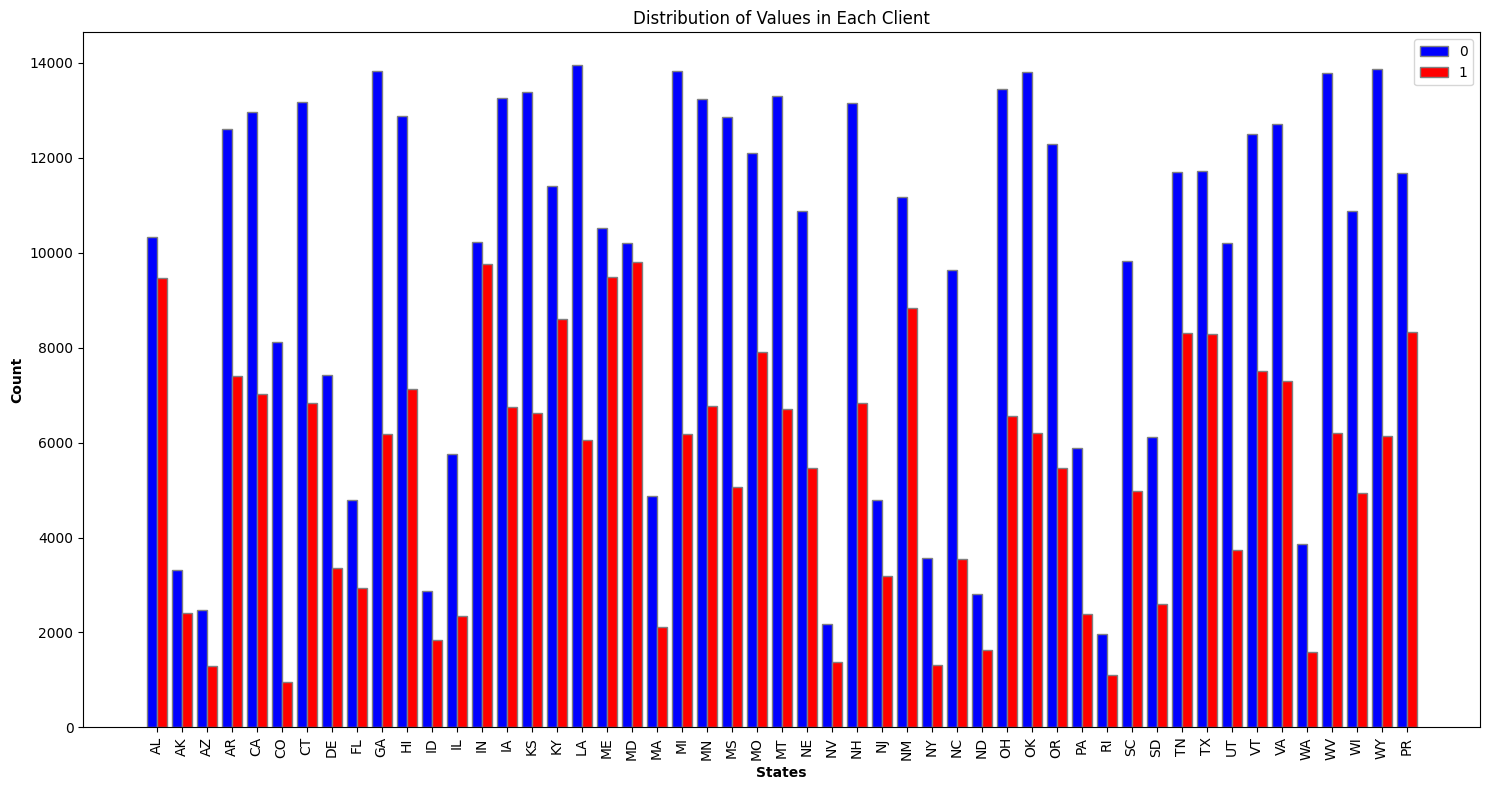

In [11]:
import matplotlib.pyplot as plt

# Plot the distribution of values in coun_list for each client
fig, ax = plt.subplots(figsize=(15, 8))

# Set the positions of the bars on the x-axis
r = np.arange(len(states))

# Extract the counts for each value (0 and 1) from coun_list
counts_0 = [counter[0] for counter in coun_list]
counts_1 = [counter[1] for counter in coun_list]

# Create the bars for each value
bars1 = ax.bar(r - 0.2, counts_0, width=0.4, color="blue", edgecolor="grey", label="0")
bars2 = ax.bar(r + 0.2, counts_1, width=0.4, color="red", edgecolor="grey", label="1")

# Add labels for the plot
ax.set_xlabel("States", fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.set_title("Distribution of Values in Each Client")
ax.set_xticks(r)
ax.set_xticklabels(states, rotation=90)

# Add legends
ax.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

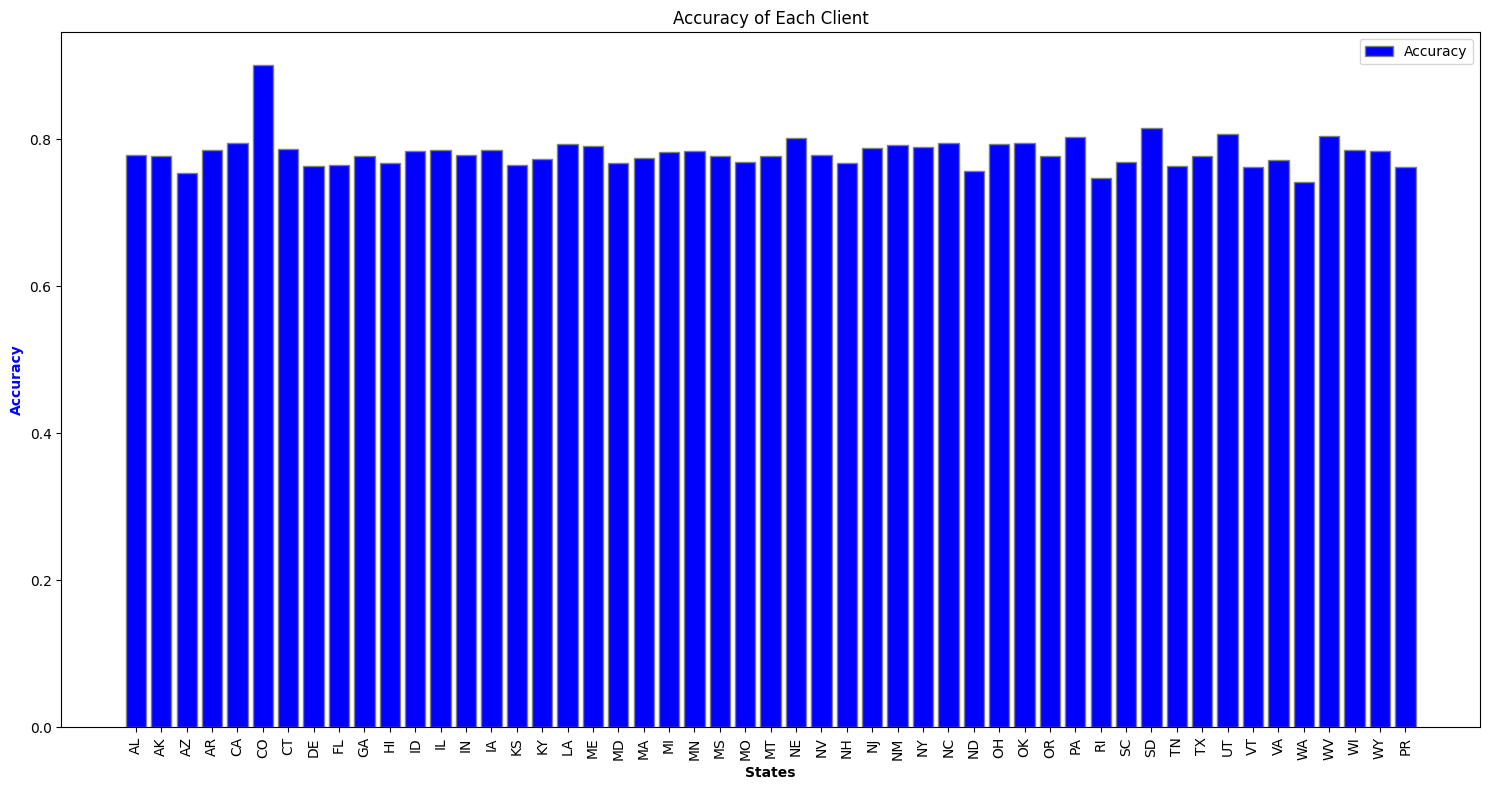

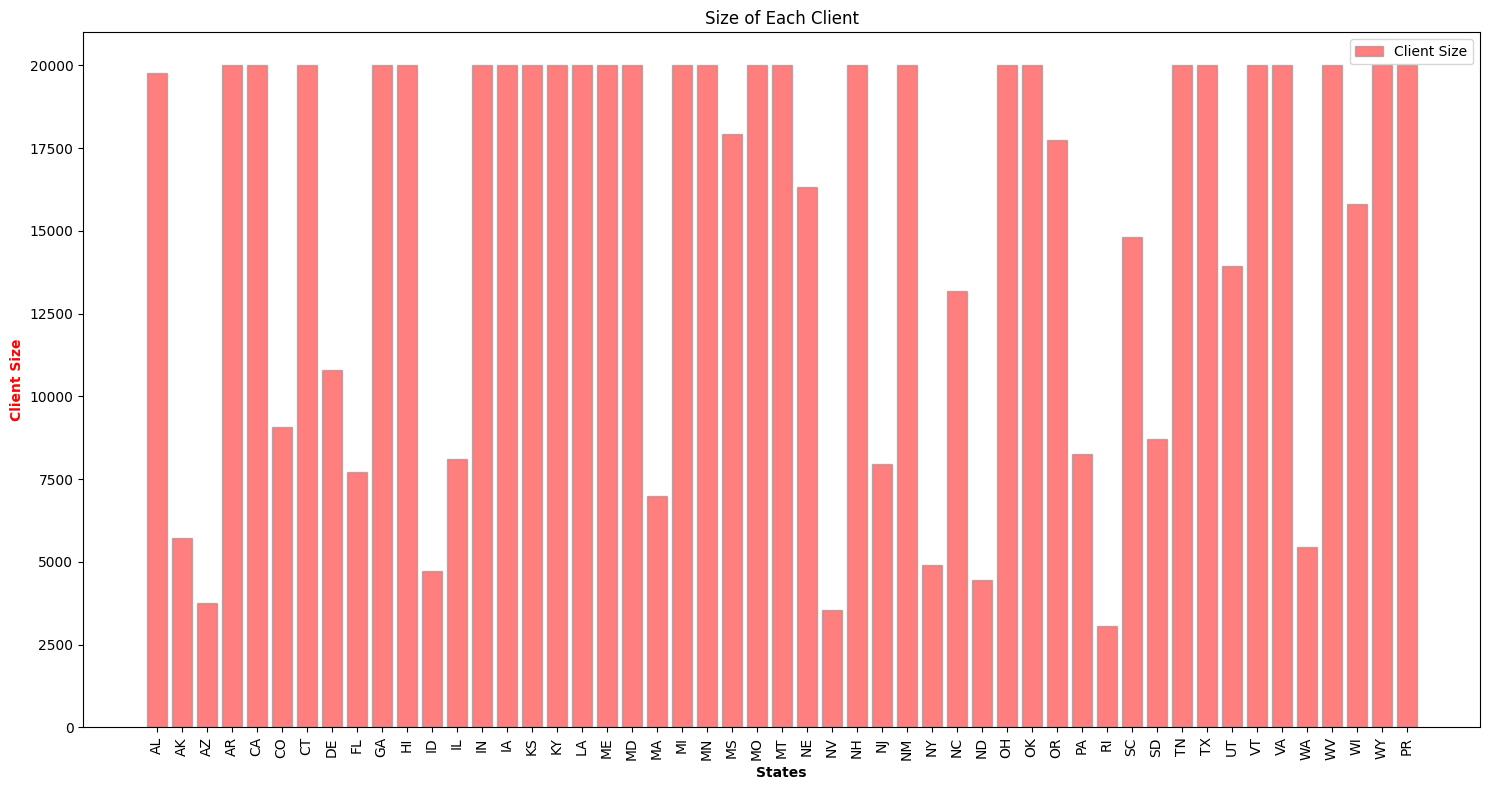

In [12]:
import matplotlib.pyplot as plt

# Plot the accuracy for each client
fig, ax1 = plt.subplots(figsize=(15, 8))

# Set the positions of the bars on the x-axis
r = np.arange(len(states))

# Create the bars for accuracy
bars1 = ax1.bar(r, accuracy_list, color="blue", edgecolor="grey", label="Accuracy")

# Add labels for accuracy
ax1.set_xlabel("States", fontweight="bold")
ax1.set_ylabel("Accuracy", fontweight="bold", color="blue")
ax1.set_title("Accuracy of Each Client")
ax1.set_xticks(r)
ax1.set_xticklabels(states, rotation=90)

# Add legends
ax1.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

# Plot the size of each client
fig, ax2 = plt.subplots(figsize=(15, 8))

# Create the bars for client size
client_sizes = [len(df) for df in reduced_df_list]
bars2 = ax2.bar(
    r, client_sizes, color="red", edgecolor="grey", alpha=0.5, label="Client Size"
)

# Add labels for client size
ax2.set_xlabel("States", fontweight="bold")
ax2.set_ylabel("Client Size", fontweight="bold", color="red")
ax2.set_title("Size of Each Client")
ax2.set_xticks(r)
ax2.set_xticklabels(states, rotation=90)

# Add legends
ax2.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()